In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #必要なライブラリをインポート（使えるようにする）

In [208]:
from sklearn.linear_model import LinearRegression #sklearnの線形回帰モデルをインポート

In [209]:
from sklearn.model_selection import train_test_split #データを学習用とテスト用に分割するための関数をインポート

In [210]:
df = pd.read_excel("result_zeebeck_1.xlsx") #実験結果を読み込んで、dfという変数に格納

In [211]:
df.columns = ['halfgold_ratio', 'doping_concentration', 'resistance_reduction'] #列名が日本語になっているので、英語に変更

In [212]:
x = df[['halfgold_ratio', 'doping_concentration']]
y = df['resistance_reduction'] #目的関数をyに入れる

In [213]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1) #学習用とテスト用にデータを分割（例: 80%学習, 20%テスト）


In [214]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# 1) 多項式回帰 (degree=3 固定)
pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])
pipe.fit(x_train, y_train)

,steps,"[('poly', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,degree,3
,interaction_only,False
,include_bias,False
,order,'C'
,copy,True
,with_mean,True
,with_std,True


In [215]:
import itertools

# 半金比率: 90,80,...,0（10刻み）
halfgold_vals = list(range(90, -1, -10))

# ドーピング濃度: 0.5〜16を1刻み
doping_vals = np.round(np.arange(0.5, 16.0 + 1e-9, 1.0), 3)

# 組み合わせ作成
predict_df = pd.DataFrame(list(itertools.product(halfgold_vals, doping_vals)),
                          columns=['halfgold_ratio', 'doping_concentration'])

predict_df['predicted_poly_deg3'] = pipe.predict(predict_df[['halfgold_ratio','doping_concentration']])

# 2) RandomForest に交互作用を入れて再学習（rf2）
X_train2 = x_train.copy()
X_test2  = x_test.copy()
X_train2['interaction'] = X_train2['halfgold_ratio'] * X_train2['doping_concentration']
X_test2['interaction']  = X_test2['halfgold_ratio'] * X_test2['doping_concentration']

rf2 = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf2.fit(X_train2, y_train)
predict_df['interaction'] = predict_df['halfgold_ratio'] * predict_df['doping_concentration']
predict_df['predicted_rf2'] = rf2.predict(predict_df[['halfgold_ratio','doping_concentration','interaction']])

# 3) 比較出力と保存
print("train/test scores: poly_deg3", pipe.score(x_train, y_train), pipe.score(x_test, y_test))
print("rf2 score:", rf2.score(X_test2, y_test))
predict_df.to_excel("predictions_poly_vs_rf2.xlsx", index=False)
print("saved: predictions_poly_vs_rf2.xlsx")


train/test scores: poly_deg3 0.8027277991434902 0.04842360399349466
rf2 score: 0.9508647123793297
saved: predictions_poly_vs_rf2.xlsx


In [216]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(x_train, y_train)

print("train score:", rf.score(x_train, y_train))
print("test score:", rf.score(x_test, y_test))
print("CV mean R2:", cross_val_score(rf, x, y, cv=5, scoring='r2').mean())

# 保存
predict_df['predicted_rf'] = rf.predict(predict_df[['halfgold_ratio','doping_concentration']])
predict_df.to_excel("predictions_rf.xlsx", index=False)
print("predictions_rf.xlsx を保存しました")


train score: 0.983154610738385
test score: 0.8912774604967102
CV mean R2: -0.8043165925461633
predictions_rf.xlsx を保存しました
CV mean R2: -0.8043165925461633
predictions_rf.xlsx を保存しました


x_train halfgold unique: [ 0 30 50 70 90]
rf.feature_importances_: [0.69608143 0.30391857]
rf2.feature_importances_: [0.50750881 0.08531298 0.40717821]

-- RF (元) の比較 (80 vs 70) --
halfgold_ratio              70        80
doping_concentration                    
0.5                   1.232383  1.232383
1.5                   1.536492  1.536492
2.5                   1.834518  1.834518
3.5                   1.850159  1.850159
4.5                   1.856381  1.856381
5.5                   1.851686  1.851686
6.5                   1.917197  1.917197
7.5                   1.922167  1.922167
8.5                   1.959468  1.959468
9.5                   1.961034  1.961034

-- RF2 (interaction) の比較 (80 vs 70) --
halfgold_ratio              70        80
doping_concentration                    
0.5                   1.232898  1.250065
1.5                   1.457889  1.552852
2.5                   1.782885  1.807530
3.5                   1.824415  1.820901
4.5                   1.835300  1.829549


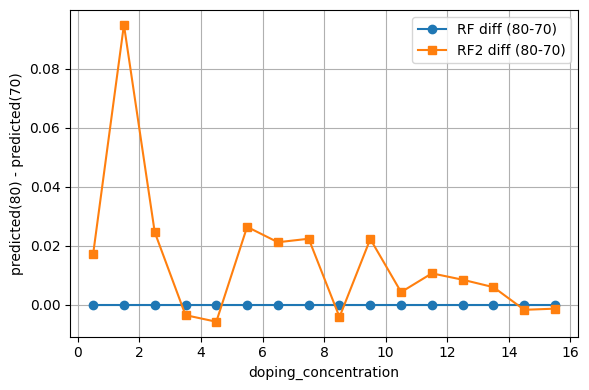

diff_80_70_comparison.png を保存しました
predictions_rf_comparison.xlsx を保存しました


In [217]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# 1) 学習データに 80 が含まれるか確認
print("x_train halfgold unique:", np.unique(x_train['halfgold_ratio']))

# 2) rf のままの予測（既にある場合はスキップ）
if 'rf' not in globals():
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(x_train, y_train)

# 3) 交互作用項を追加して再学習 (rf2)
X_train2 = x_train.copy()
X_test2  = x_test.copy()
X_train2['interaction'] = X_train2['halfgold_ratio'] * X_train2['doping_concentration']
X_test2['interaction']  = X_test2['halfgold_ratio'] * X_test2['doping_concentration']

rf2 = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf2.fit(X_train2, y_train)
print("rf.feature_importances_:", rf.feature_importances_)
print("rf2.feature_importances_:", rf2.feature_importances_)

# 4) 予測用データフレームがなければ作成
if 'predict_df' not in globals():
    import itertools
    halfgold_vals = list(range(90, -1, -10))
    doping_vals = np.round(np.arange(0.5, 16.0 + 1e-9, 1.0), 3)
    predict_df = pd.DataFrame(list(itertools.product(halfgold_vals, doping_vals)),
                              columns=['halfgold_ratio', 'doping_concentration'])

predict_df['predicted_rf'] = rf.predict(predict_df[['halfgold_ratio','doping_concentration']])
predict_df['interaction'] = predict_df['halfgold_ratio'] * predict_df['doping_concentration']
predict_df['predicted_rf2'] = rf2.predict(predict_df[['halfgold_ratio','doping_concentration','interaction']])

# 5) 80 と 70 の差分を表示・プロット
comp = predict_df[predict_df['halfgold_ratio'].isin([80,70])].pivot_table(
    index='doping_concentration', columns='halfgold_ratio',
    values=['predicted_rf','predicted_rf2']
).sort_index()

print("\n-- RF (元) の比較 (80 vs 70) --")
print(comp['predicted_rf'].head(10))
print("\n-- RF2 (interaction) の比較 (80 vs 70) --")
print(comp['predicted_rf2'].head(10))

# プロット（ドーピングごとの差分）
plt.figure(figsize=(6,4))
d = comp.index.values
diff_rf = comp['predicted_rf'][80] - comp['predicted_rf'][70]
diff_rf2 = comp['predicted_rf2'][80] - comp['predicted_rf2'][70]
plt.plot(d, diff_rf, label='RF diff (80-70)', marker='o')
plt.plot(d, diff_rf2, label='RF2 diff (80-70)', marker='s')
plt.xlabel('doping_concentration')
plt.ylabel('predicted(80) - predicted(70)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('diff_80_70_comparison.png')
plt.show()
print("diff_80_70_comparison.png を保存しました")

# 6) 保存
predict_df.to_excel("predictions_rf_comparison.xlsx", index=False)
print("predictions_rf_comparison.xlsx を保存しました")


predicted_poly_deg3 diff min/mean/max: 0.0174794851308977 0.0609493572097794 0.07908502432683684
predicted_rf diff min/mean/max: 0.0 0.0 0.0
predicted_rf2 diff min/mean/max: -0.005750509637070911 0.015133866794880393 0.09496313369809561
predicted_gbr diff min/mean/max: -0.0009868473529937027 0.035612222710804914 0.33736510148220056
predicted_svr diff min/mean/max: -0.015126249605833753 0.03266174491658927 0.09462877643353229


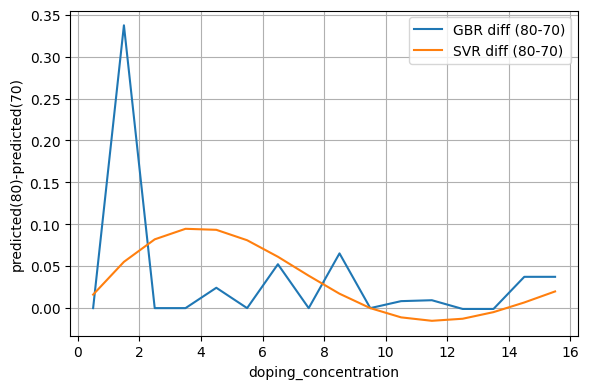

saved: predictions_compare_more_models.xlsx


In [218]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Gradient Boosting: 学習（X_train2 があればそれで、なければ x_train）
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)
gbr.fit(X_train2 if 'X_train2' in globals() else x_train, y_train)

# predict_df に学習時と同じ列（名・順）を用意してから予測する
if 'X_train2' in globals():
    feature_cols = X_train2.columns.tolist()
else:
    feature_cols = x_train.columns.tolist()

# 必要なら interaction を作る
if 'interaction' in feature_cols and 'interaction' not in predict_df.columns:
    predict_df['interaction'] = predict_df['halfgold_ratio'] * predict_df['doping_concentration']

# X_pred を feature_cols の順で切り出す（欠損列があればエラーを出す）
missing = [c for c in feature_cols if c not in predict_df.columns]
if missing:
    raise RuntimeError(f"predict_df に必要な列がありません: {missing}")

X_pred_gbr = predict_df[feature_cols]
predict_df['predicted_gbr'] = gbr.predict(X_pred_gbr)

# SVR (RBF) with scaling
svr_pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel='rbf', C=10, epsilon=0.01))])
svr_pipe.fit(x_train, y_train)
predict_df['predicted_svr'] = svr_pipe.predict(predict_df[['halfgold_ratio','doping_concentration']])

# 比較: 70 vs 80 の差分（各モデル）
models = ['predicted_poly_deg3','predicted_rf','predicted_rf2','predicted_gbr','predicted_svr']
for m in [c for c in models if c in predict_df.columns]:
    a70 = predict_df.loc[predict_df['halfgold_ratio']==70, m].values
    a80 = predict_df.loc[predict_df['halfgold_ratio']==80, m].values
    if len(a70)==len(a80):
        diff = a80 - a70
        print(f"{m} diff min/mean/max:", diff.min(), diff.mean(), diff.max())
    else:
        print(f"{m}: サンプル数不一致")

# プロット例（gbr と svr）
plt.figure(figsize=(6,4))
d = predict_df[predict_df['halfgold_ratio'].isin([70,80])].pivot_table(index='doping_concentration', columns='halfgold_ratio', values='predicted_gbr').index
plt.plot(d, predict_df[predict_df['halfgold_ratio']==80].sort_values('doping_concentration')['predicted_gbr'].values - predict_df[predict_df['halfgold_ratio']==70].sort_values('doping_concentration')['predicted_gbr'].values, label='GBR diff (80-70)')
plt.plot(d, predict_df[predict_df['halfgold_ratio']==80].sort_values('doping_concentration')['predicted_svr'].values - predict_df[predict_df['halfgold_ratio']==70].sort_values('doping_concentration')['predicted_svr'].values, label='SVR diff (80-70)')
plt.xlabel('doping_concentration'); plt.ylabel('predicted(80)-predicted(70)'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig('diff_gbr_svr_80_70.png'); plt.show()

# 保存
predict_df.to_excel("predictions_compare_more_models.xlsx", index=False)
print("saved: predictions_compare_more_models.xlsx")